In [2]:
from helper.modelling import recursive_feature_selector
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from utils.constant import PICKLE_PATH, RESULT_PATH
import numpy as np

#### Recursive Feature Selection using LightGBM

In [3]:
train_data = pd.read_pickle(os.path.join(PICKLE_PATH, 'train_data_final.pkl'))
test_data = pd.read_pickle(os.path.join(PICKLE_PATH, 'test_data_final.pkl'))

# removing the SK_ID_CURR from training and test data
train_data = train_data.drop(['SK_ID_CURR'], axis=1)
skid_test = test_data.pop('SK_ID_CURR')
# extracting the class labels for training data
target_train = train_data.pop('TARGET')

empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <= 1:
        empty_columns.append(col)

print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis=1)
test_data = test_data.drop(empty_columns, axis=1)
# instantiating the class recursive_feature_selector
feature_selector = recursive_feature_selector(train_data, test_data, target_train)
train, test = feature_selector.main()
important_columns = feature_selector.important_columns

# standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train)
x_test_std = scaler.fit_transform(test)
y_train = target_train

# replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

There are 24 columns with just 1 unique value
Removing these from dataset
Starting Feature Selection...
Iteration 1:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1032
	Cross Validation score = 0.7973566449599272
Iteration 2:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1111
	Cross Validation score = 0.712131398377564

Done Selecting Features.
Total columns removed = 340

Initial Shape of train_data = (307507, 1451)
Final Shape of train_data = (307507, 1111)

Total Time Taken = 0:02:19.375173


#### Logistic Regression L2 Regularization

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits


/Users/jeremy_gp/opt/anaconda3/envs/QIDS/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/jeremy_gp/opt/anaconda3/envs/QIDS/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/jeremy_gp/opt/anaconda3/envs/QIDS/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/jeremy_gp/opt/anaconda3/envs/QIDS/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in v

Done.
Time elapsed = 0:10:22.342730


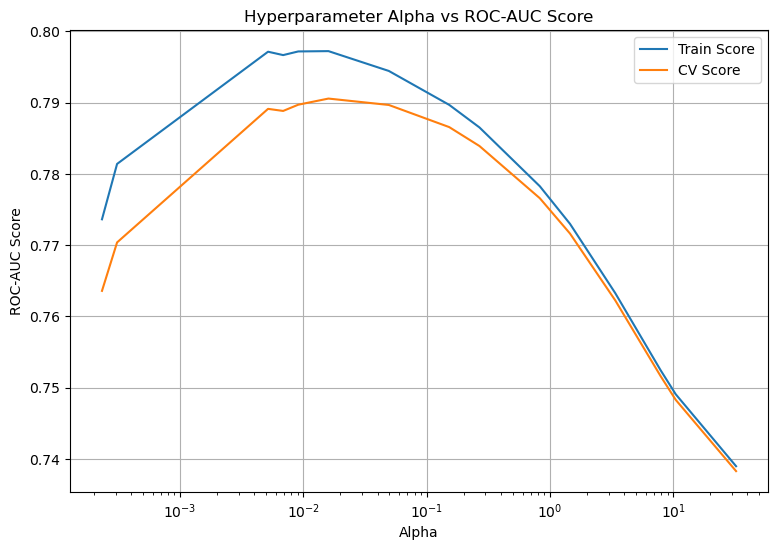

In [4]:
from sklearn.linear_model import SGDClassifier
from helper.modelling import modelling
import matplotlib.pyplot as plt

params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

sgd_lr_l2 = modelling(clf, x_train_std, y_train, x_test_std)

# do randomized search cv first
sgd_lr_l2.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2)

#visualizing the cv results
cv_results = sgd_lr_l2.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:00:47.852616

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.4712108407857459

Train Results:
	ROC-AUC Score = 0.796117736245753
	Precision Score = 0.17876761174180367
	Recall Score = 0.7472306143001007
CV Results:
	ROC-AUC Score = 0.7904989911302266
	Precision Score = 0.17756218953835387
	Recall Score = 0.7357905337361531
Confusion Matrix of CV data:


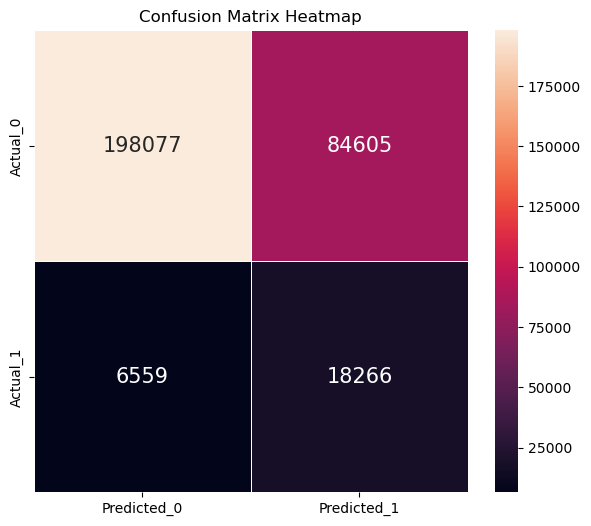

Distribution of Original Class Labels and Predicted CV and Test Class Labels


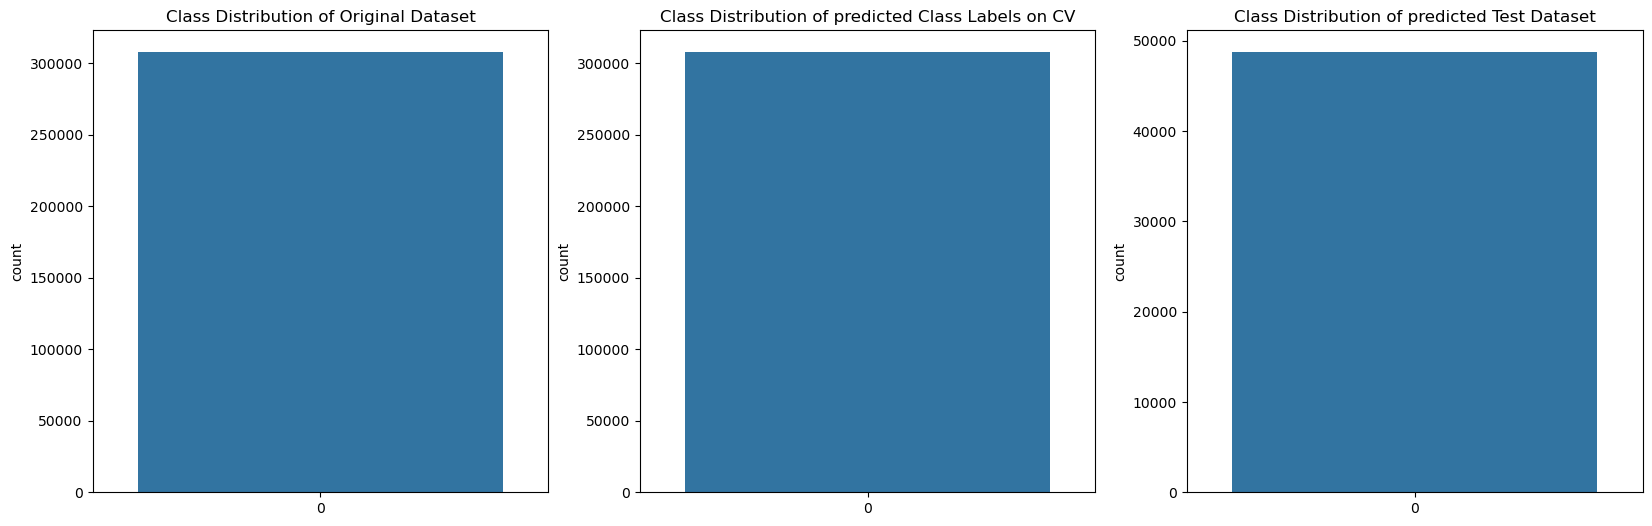

In [5]:
#training on best parameters
sgd_lr_l2.train_on_best_params()
#showing the results
sgd_lr_l2.results_on_best_params('linear')
#save the results
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : sgd_lr_l2.test_preds_probas}).to_csv(RESULT_PATH + '/SGD_LR_L2_penalty.csv',index = False)

#### Linear SVM

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Done.
Time elapsed = 0:15:09.850163


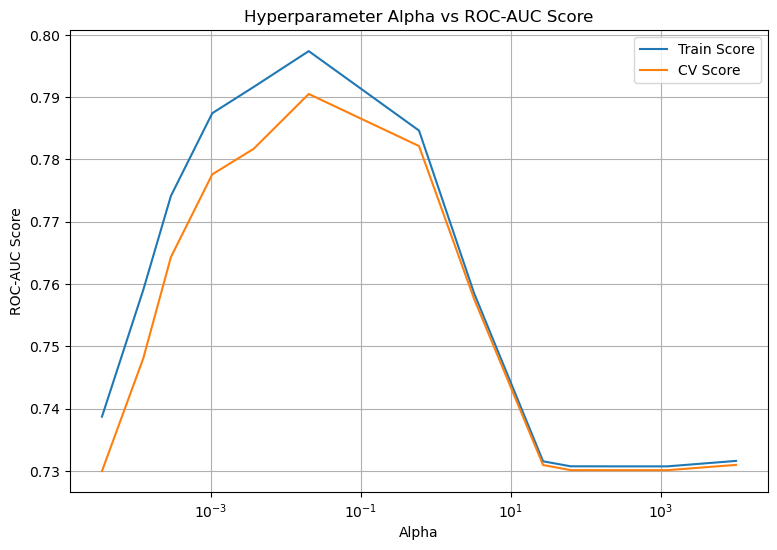

In [6]:
params = {
    'loss' : 'hinge',
    'class_weight' : 'balanced',
    'random_state' : 129,
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {
    'alpha' : np.logspace(-5,4)
}
linear_svm = modelling(clf, x_train_std, y_train, x_test_std, calibration = True)

#lets do randomized search cv first
linear_svm.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2, random_state = 693)

#visualizing the cv results
cv_results = linear_svm.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:03:37.860552

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.08314397852892703

Train Results:
	ROC-AUC Score = 0.7975741309791716
	Precision Score = 0.18550374832527078
	Recall Score = 0.7306344410876133
CV Results:
	ROC-AUC Score = 0.79103761572017
	Precision Score = 0.18273899383899792
	Recall Score = 0.7216515609264854
Confusion Matrix of CV data:


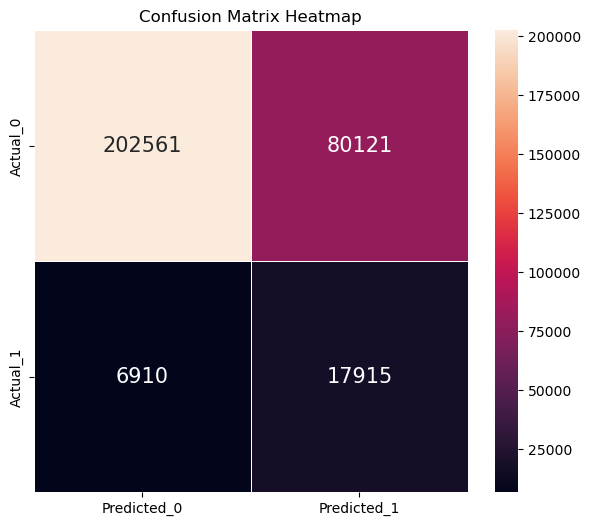

Distribution of Original Class Labels and Predicted CV and Test Class Labels


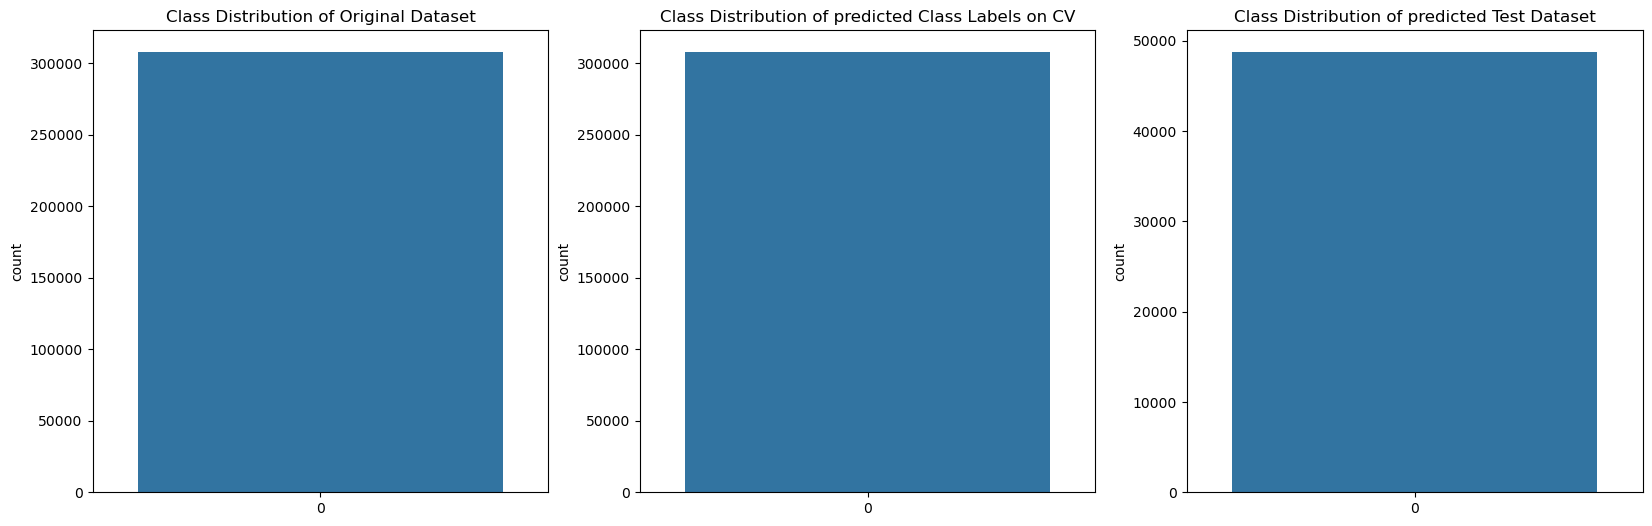

In [7]:
#training on best parameters
linear_svm.train_on_best_params()
#showing the results
linear_svm.results_on_best_params('linear')
# save the results
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : linear_svm.test_preds_probas}).to_csv(RESULT_PATH + '/SGD_Linear_SVM.csv',index = False)